In [2]:
import numpy as np
import tensorflow as tf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [3]:
unet = tf.keras.models.load_model(r"C:\Users\aashutosh kumar\Downloads\LD.h5")  # Replace with your model path

In [4]:
intensity = ctrl.Antecedent(np.arange(0, 256, 1), 'intensity')
confidence = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')
category = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'category')

# Membership functions
intensity['low'] = fuzz.trimf(intensity.universe, [0, 0, 128])
intensity['high'] = fuzz.trimf(intensity.universe, [128, 255, 255])
confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['high'] = fuzz.trimf(confidence.universe, [0.5, 1, 1])
category['background'] = fuzz.trimf(category.universe, [0, 0, 0.5])
category['lane'] = fuzz.trimf(category.universe, [0.5, 1, 1])

# Define fuzzy rules
rule1 = ctrl.Rule(intensity['low'] & confidence['low'], category['background'])
rule2 = ctrl.Rule(intensity['high'] & confidence['high'], category['lane'])

# Create fuzzy control system
fuzzy_ctrl = ctrl.ControlSystem([rule1, rule2])
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_ctrl)

# Load an input image for prediction (example)
def preprocess_image(image_path):
    """Preprocess the image for the U-Net model."""
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256), color_mode="grayscale")
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    
    # Convert grayscale image to 3 channels
    image = np.repeat(image, 3, axis=-1)  # Repeat the grayscale values across 3 channels
    
    # Expand dimensions to match the input shape (batch_size, height, width, channels)
    image = np.expand_dims(image, axis=0)
    return image


# Replace with your test image
image_path = r"D:\Research\Dataset\train\images\0313-1_2460.jpg"
input_image = preprocess_image(image_path)

# Predict mask using U-Net
predicted_mask = unet.predict(input_image)[0]

# Apply fuzzy logic to refine U-Net predictions
refined_mask = np.zeros_like(predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


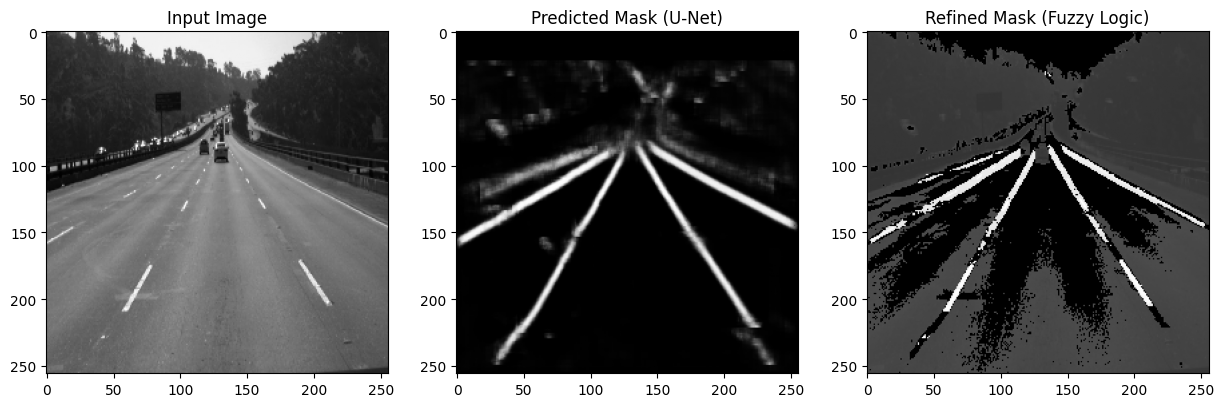

In [12]:
# Refine the predicted mask using fuzzy logic
for i in range(predicted_mask.shape[0]):
    for j in range(predicted_mask.shape[1]):
        # Get pixel intensity and prediction confidence
        intensity_value = input_image[0, i, j, 0] * 255  # Rescale intensity to 0-255
        confidence_value = predicted_mask[i, j, 0]       # Predicted confidence
        
        # Fuzzy inference
        fuzzy_sim.input['intensity'] = intensity_value
        fuzzy_sim.input['confidence'] = confidence_value
        fuzzy_sim.compute()

        # # Debugging: Print fuzzy output for each pixel
        # print(f"Intensity: {intensity_value}, Confidence: {confidence_value}")
        # print(f"Fuzzy Output: {fuzzy_sim.output}")  # Debug output
        
        # Check for 'category' key in fuzzy output
        if 'category' in fuzzy_sim.output:
            refined_mask[i, j, 0] = fuzzy_sim.output['category']
        else:
            refined_mask[i, j, 0] = 0  # Default value in case of error

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(input_image[0, :, :, 0], cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask (U-Net)")
plt.imshow(predicted_mask[:, :, 0], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Refined Mask (Fuzzy Logic)")
plt.imshow(refined_mask[:, :, 0], cmap='gray')
plt.show()

In [6]:
import cv2
import numpy as np
import tensorflow as tf
import skfuzzy as fuzz
from skfuzzy import control as ctrl

intensity = ctrl.Antecedent(np.arange(0, 256, 1), 'intensity')
confidence = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')
category = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'category')

intensity['low'] = fuzz.trimf(intensity.universe, [0, 0, 128])
intensity['high'] = fuzz.trimf(intensity.universe, [128, 255, 255])
confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['high'] = fuzz.trimf(confidence.universe, [0.5, 1, 1])
category['background'] = fuzz.trimf(category.universe, [0, 0, 0.5])
category['lane'] = fuzz.trimf(category.universe, [0.5, 1, 1])

rule1 = ctrl.Rule(intensity['low'] & confidence['low'], category['background'])
rule2 = ctrl.Rule(intensity['high'] & confidence['high'], category['lane'])

fuzzy_ctrl = ctrl.ControlSystem([rule1, rule2])
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_ctrl)

def process_video(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)  # Open video
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_resized = cv2.resize(frame, (256, 256))  # Resize to match model input
        frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        input_image = np.expand_dims(frame_gray, axis=-1) / 255.0  # Normalize and expand dimensions
        input_image = np.repeat(input_image, 3, axis=-1)  # Convert to 3 channels for U-Net
        input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
        
        # Predict mask using U-Net
        predicted_mask = unet.predict(input_image)[0]

        # Initialize refined mask
        refined_mask = np.zeros_like(predicted_mask)

        # Apply fuzzy logic to refine the mask
        for i in range(predicted_mask.shape[0]):
            for j in range(predicted_mask.shape[1]):
                intensity_value = input_image[0, i, j, 0] * 255  # Rescale intensity to 0-255
                confidence_value = predicted_mask[i, j, 0]       # Predicted confidence

                # Fuzzy inference
                fuzzy_sim.input['intensity'] = intensity_value
                fuzzy_sim.input['confidence'] = confidence_value
                fuzzy_sim.compute()

                # Refine the mask using fuzzy output
                if 'category' in fuzzy_sim.output:
                    refined_mask[i, j, 0] = fuzzy_sim.output['category']
                else:
                    refined_mask[i, j, 0] = 0  # Default value if error occurs

        # Rescale refined mask to original frame size
        refined_mask_resized = cv2.resize(refined_mask, (frame_width, frame_height))

        # Display or save the refined frame
        refined_frame = np.uint8(refined_mask_resized * 255)  # Convert to 8-bit grayscale
        out.write(refined_frame)  # Write frame to output video

        # Optionally, display the result (remove in production)
        cv2.imshow('Refined Mask', refined_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Path to input and output videos
input_video_path = r"C:\Projects\Lane_Detection\80400-572395752_tiny.mp4"
output_video_path = r"D:\Research\Road-Landmark-Detection"

# Process the video
process_video(input_video_path, output_video_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


KeyboardInterrupt: 

In [12]:
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix

# Function to compute IoU, accuracy, precision, recall, and F1 score
def compute_metrics(pred_mask, ground_truth):
    # Ensure binary masks (0 or 1)
    pred_mask = (pred_mask > 0.5).astype(int)  # Thresholding predicted mask
    ground_truth = (ground_truth > 0.5).astype(int)  # Thresholding ground truth mask

    # Flatten the images to 1D for comparison
    pred_mask_flat = pred_mask.flatten()
    ground_truth_flat = ground_truth.flatten()

    # Confusion matrix (True positives, False positives, True negatives, False negatives)
    tn, fp, fn, tp = confusion_matrix(ground_truth_flat, pred_mask_flat).ravel()

    # Calculate IoU (Intersection over Union)
    iou = tp / (tp + fp + fn)

    # Calculate Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Calculate Precision and Recall
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return iou, accuracy, precision, recall, f1_score

# Function to evaluate U-Net and U-Net + Fuzzy refinement
def evaluate_unet_vs_fuzzy(input_image_path, unet_model, fuzzy_sim, ground_truth_mask):
    input_image = preprocess_image(input_image_path)

    # Predict mask using U-Net
    predicted_mask_unet = unet_model.predict(input_image)[0]

    # Initialize refined mask
    refined_mask_fuzzy = np.zeros_like(predicted_mask_unet)

    # Refine the predicted mask using fuzzy logic
    for i in range(predicted_mask_unet.shape[0]):
        for j in range(predicted_mask_unet.shape[1]):
            # Get pixel intensity and prediction confidence
            intensity_value = input_image[0, i, j, 0] * 255  # Rescale intensity to 0-255
            confidence_value = predicted_mask_unet[i, j, 0]  # Predicted confidence
            
            # Fuzzy inference
            fuzzy_sim.input['intensity'] = intensity_value
            fuzzy_sim.input['confidence'] = confidence_value
            fuzzy_sim.compute()

            # Ensure fuzzy output is available
            if 'category' in fuzzy_sim.output:
                refined_mask_fuzzy[i, j, 0] = fuzzy_sim.output['category']
            else:
                refined_mask_fuzzy[i, j, 0] = 0  # Default value if 'category' is missing

    # Compute metrics for U-Net prediction
    iou_unet, accuracy_unet, precision_unet, recall_unet, f1_score_unet = compute_metrics(predicted_mask_unet, ground_truth_mask)

    # Compute metrics for refined mask (U-Net + Fuzzy)
    iou_fuzzy, accuracy_fuzzy, precision_fuzzy, recall_fuzzy, f1_score_fuzzy = compute_metrics(refined_mask_fuzzy, ground_truth_mask)

    # Print results for U-Net prediction
    print("Metrics for U-Net Prediction:")
    print(f"IoU: {iou_unet:.4f}")
    print(f"Accuracy: {accuracy_unet:.4f}")
    print(f"Precision: {precision_unet:.4f}")
    print(f"Recall: {recall_unet:.4f}")
    print(f"F1 Score: {f1_score_unet:.4f}")

    # Print results for U-Net + Fuzzy refinement
    print("\nMetrics for U-Net + Fuzzy Refinement:")
    print(f"IoU: {iou_fuzzy:.4f}")
    print(f"Accuracy: {accuracy_fuzzy:.4f}")
    print(f"Precision: {precision_fuzzy:.4f}")
    print(f"Recall: {recall_fuzzy:.4f}")
    print(f"F1 Score: {f1_score_fuzzy:.4f}")

# Example usage
input_image_path = r"D:\Research\Dataset\test\images\0313-1_4580.jpg"  # Replace with actual image path
ground_truth_mask = cv2.imread(r"D:\Research\Dataset\test\masks\0313-1_4580.jpg", cv2.IMREAD_GRAYSCALE)  # Load ground truth mask
ground_truth_mask = cv2.resize(ground_truth_mask, (256, 256))  # Resize to match model input size

evaluate_unet_vs_fuzzy(input_image_path, unet, fuzzy_sim, ground_truth_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Metrics for U-Net Prediction:
IoU: 0.4521
Accuracy: 0.9649
Precision: 0.8439
Recall: 0.4934
F1 Score: 0.6227

Metrics for U-Net + Fuzzy Refinement:
IoU: 0.1008
Accuracy: 0.9465
Precision: 0.8772
Recall: 0.1022
F1 Score: 0.1831
